## QPE Implementation

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit.library import Diagonal
from qiskit.circuit.library import DiagonalGate
from qiskit.circuit.library import MCPhaseGate

import matplotlib.pyplot as plt

import numpy as np

## Problem Statement

We will write a function that takes as input an $n$-qubit unitary, that is, $U|\psi\rangle_n = e^{2 \pi i \theta(\psi)}|\psi\rangle_n$ such that all values of $e^{2 \pi i \theta(\psi)}$ are distinct. We will assume that:

1. There exists a number $d \in \mathbb{Z}_+$ such that $2^d\theta(\psi) \in \mathbb{Z}$.
2. There exists a unique $x \in \mathbb{F}_2^n$ such that $e^{2\pi i \theta(\psi)} = e^{2\pi i t}$ for some $t \in [0,1]$.

The first statement implies that $\theta(\psi)$ is a rational, while the second statement implies that $t = \theta$ for some $\psi$ (if we restrict ourselves to the same branch of the $\log$ function). So, $t$ is also a rational.

## Helper functions

In [178]:
## Helper functions for testing.
def bit_string(num,n): # converts a number to binary bit_string
    """Converts a number to its binary string with MSB to LSB from left to right.
    Input: number (num), n (number of bits that should be in result)
    """
    maxi = 2**n
    rem = num%(2**n)

    bit_string = ''# 2^(n-1) ... 2^0 

    for i in range(n-1,-1,-1):
        append = str(rem//(2**i))
        bit_string = bit_string + append
        rem = rem%(2**i)
    return bit_string

def binary_to_num(bit_str):
    """Convert a bit-string to a number.
    Input : bit-string in binary
    Output: number 
    """
    num=0
    n=len(bit_str)
    
    for i in range(n):
        bit = int(bit_str[i])
        if bit < 0 or bit > 1:
            print("Fatal error. You did not input a bit string.Exiting.")
            return 0
        num = num + bit*2**(n-1-i)
    return num


def bit_string_input(t,psi,d,n):
    """ converts psi number to bit string input."""
    
    bit_str_t = bit_string(t,d)[::-1]
    bit_str_psi = bit_string(psi,n)[::-1]
    #for i in range(d):
    #    bit_str = "0"+bit_str #first d quibits are zero.
    return bit_str_t + bit_str_psi

def num_output(bit_string,d,n):
    """ converts psi number to bit string input."""
    
    if len(bit_string)!= d+n:
        raise Exception("Error. Exit.")
    summ = 0

    for i in range(n):
        summ = summ + 2**i*int(bit_string[i+d])

    print("The output value of psi is", summ)
    
    #summ=0 
    #for i in range(d):
    #    summ = summ + 2**i*int(bit_string[i]) # read what number is in the |0> qubits after QPE.
        
    return summ

def bit_to_state(bit_str): #convert bit_string to state_vector
    """ Converts a bit-string to an input state vector for the circuit.
    """
    bit_str = bit_str[::-1]
    #
    return Statevector.from_label(bit_str)
def state_to_bit(statevector,n): # converts state_vector to bit_string
    """ Converts an input statevector to a bit-string of length n
    """
    num = np.nonzero(np.round(np.real(statevector)))[0][0]
   
    return bit_string(num,n)


In [3]:
## Inverse QFT 
def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)
        
    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
        inverse_QFT_circuit.h(q)

    

    return inverse_QFT_circuit

## Quantum Fourier Transform
def quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    QFT_circuit = QuantumCircuit(quantum_register, name=f"QFT")

    

    for i, q in enumerate(quantum_register, start=1):
        QFT_circuit.h(q)
        for j, p in enumerate(quantum_register[i:], start=1):
            QFT_circuit.cp(np.pi / (1 << j), q, p) 

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        QFT_circuit.swap(q, p)
    
    return QFT_circuit

In [ ]:
def theta_input(d,n):
    """Computes the possible values of thetas (modulo 2^d) for a given value of d. Gives them in a random order in array."""
    possible_thetas = np.arange(2**d)/2**d
    return np.random.choice(possible_thetas, size=2**n,replace=False)
    
    

def power_diag_U(power, n, thetas):
    """Computes the diagonal [(e^{2 pi i theta})^power] for all theta"""
    diagonals = np.array([])
    if 2**n != len(thetas):
        raise Exception("2^n should be the same length as the array of phases.")
    
    for theta in thetas:
        diagonals = np.append(diagonals, np.exp(2*np.pi*1.j*theta*power))
 
    return diagonals.tolist()

def power_U(power, n, thetas):
    """Turns the diagonal into the U^power gate using qiskit's built-in DiagonalGate."""
    diagonals = power_diag_U(power, n, thetas)
    qc = QuantumCircuit(n, name=f"U")

    qc.append(DiagonalGate(diagonals), range(n)) #uses qiskit function DiagonalGate.

    return qc

# I will also need the inverse of power_U
def power_U_inverse(power,n,thetas):
    """Finds the inverse of power_U as U^{-power}."""
    diagonals = (np.array(power_diag_U(power, n, thetas))**(-1)).tolist()

    qc = QuantumCircuit(n, name=f"U_inv")

    qc.append(DiagonalGate(diagonals), range(n))

    return qc
    

## Quantum Phase Estimation (QPE) circuit

This section builds the QPE circuit using the $U$ gates (and their powers) as well as the inverse QFT. Recall that the QPE acts as
\begin{equation}
QPE |0\rangle_d |\psi\rangle_n = |2^d\theta(\psi)\rangle_d |\psi\rangle_n
\end{equation}
where $U|\psi\rangle_n = e^{2 \pi i \theta(\psi)}|\psi\rangle_n$. 

(Also note that in general, the same $QPE |y\rangle_d |\psi\rangle_n = |y \oplus 2^d\theta(\psi)\rangle_d|\psi\rangle_n$ will not hold).

A benchmark example is provided below for $n = d = 3$.

In [100]:
def QPE(d,n,thetas):
    """Computes the QPE circuit given d,n, and the list of prepared thetas using 'theta_input'."""
    
    qr_0 = QuantumRegister(size=d, name="0")
    qr_psi = QuantumRegister(size=n, name="psi")

    qc = QuantumCircuit(qr_0, qr_psi,name=f'QPE')

    #A boolean to insert a tensor product of n hadamards on psi. This is 
    #qc.h(qr_psi)

    
    #Hadamard gates on each |0>_d
    
    for i in range(d):
        qc.h(qr_0[i])

        U_i = power_U(2**i,n,thetas).to_gate(label="U"+str(i))
        U_i_controlled = U_i.control(1)


        qc.append(U_i_controlled, [qr_0[i]] + qr_psi[:])

    

    #Swap

    for q, p in zip(qr_0[:d >> 1], reversed(qr_0[d >> 1:])):
        qc.swap(q, p)
    
    
    #Inverse QFT
    qc.append(inverse_quantum_fourier_transform(d),qr_0[:])

    #Swap
    for q, p in zip(qr_0[:d >> 1], reversed(qr_0[d >> 1:])):
        qc.swap(q, p)

    return qc

    

    
    

In [107]:
#Benchmark example. Here we use a fixed list of thetas 
d = 3
n = 3
thetas = [0.5,   0.,    0.75,  0.25,  0.375, 0.625, 0.125, 0.875]
print(thetas)

[0.5, 0.0, 0.75, 0.25, 0.375, 0.625, 0.125, 0.875]


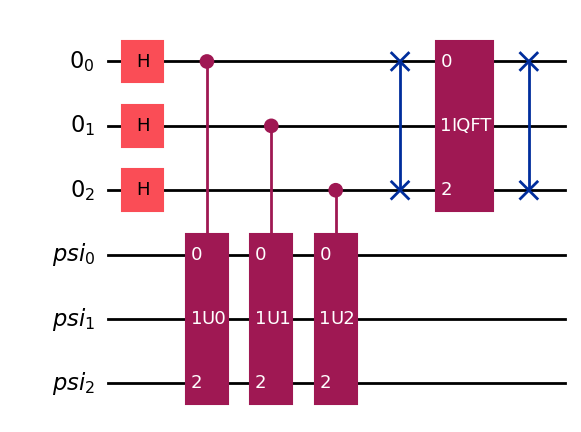

In [108]:
#Draw the QPE circuit.
qpe = QPE(d,n,thetas)
qpe.draw(output="mpl")

To check that the QPE works, we add a tensor product of Hadamard gates $H^{\otimes n}$ on $|\psi\rangle_n$ to see what the QPE does to each basis state.

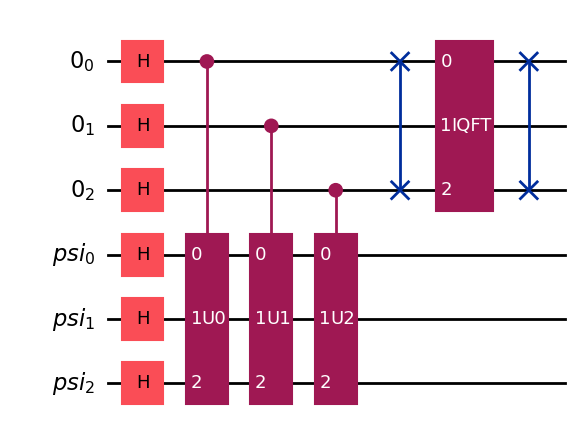

In [109]:
quantum_register_0 = QuantumRegister(3,name="0")
quantum_register_psi = QuantumRegister(3,name="psi")
qc = QuantumCircuit(quantum_register_0, quantum_register_psi)
qc.h(quantum_register_psi)
qc.compose(qpe,inplace=True)
qc.draw(output="mpl")

In [110]:
#Ok the qpe works as expected. 
Statevector(qc).draw("Latex")

<IPython.core.display.Latex object>

In [111]:
thetas 

[0.5, 0.0, 0.75, 0.25, 0.375, 0.625, 0.125, 0.875]

Above we print the $\theta(\psi)$ values where the $\theta$ corresponding to each $\psi = 0, \ldots, 7$ value can be interpreted as the index of the array.

Here, we see that the QPE works as expected. For example when $|\psi\rangle = |100\rangle_3 = |4\rangle_3$, the eigenvalue is $e^{2\pi i \theta(\psi=4)}$ which corresponds to an angle $2^d \theta(\psi=4) = 0.375 \times 2^3 = 0.375\times 8 = 3$.
This agrees with the top qubits transforming as $|0\rangle_3 \to |3\rangle_3 = | 0 1 1 \rangle_3$.
Thus the state combination is $|100 011\rangle$.

Similarly, all the other states can be understood in the same way, validating the action of the QPE.


## Construction of $U_f(t)$

Here we will construct an oracle $U_{f_t}$ for $f_t : \mathbb{F}_2^n \to \{0,1\}$ such that $U_{f_t} |0\rangle_d  |\psi\rangle_n = (-1)^{f_t(\psi)}|2^d \theta(\psi)\rangle_d |\psi\rangle_n$ where
\begin{equation}
f_t(\psi) = \begin{cases} 1 \quad \text{if}\quad \theta(\psi) = t \\ 0 \quad \text{otherwise}  \end{cases}
\end{equation}
In plain language, this just means that the basis state corresponding to the key $t$ through the relation $\theta(\psi)=t$ is the only one to pick up a minus sign.

We will need first the inverse of the QPE.

In [35]:
## We will need the inverse of QPE

def QPE_dagger(d,n,thetas):
    qr_0 = QuantumRegister(size=d, name="0")
    qr_psi = QuantumRegister(size=n, name="psi")

    qc = QuantumCircuit(qr_0, qr_psi,name=f'QPE_dagger')


    #Swap
    for q, p in zip(qr_0[:d >> 1], reversed(qr_0[d >> 1:])):
        qc.swap(q, p)

    # QFT
    qc.append(quantum_fourier_transform(d),qr_0[:])

       #Swap

    for q, p in zip(qr_0[:d >> 1], reversed(qr_0[d >> 1:])):
        qc.swap(q, p)
    

    
    #Hadamard gates on each |0>_d
    
    for i in range(d):
        U_i_inv = power_U_inverse(2**((d-1)-i),n,thetas).to_gate(label="U_inv"+str(d-1-i))
        U_i_inv_controlled = U_i_inv.control(1)

        qc.append(U_i_inv_controlled, [qr_0[(d-1)-i]] + qr_psi[:])
        
        qc.h(qr_0[(d-1)-i])
    

    return qc
        

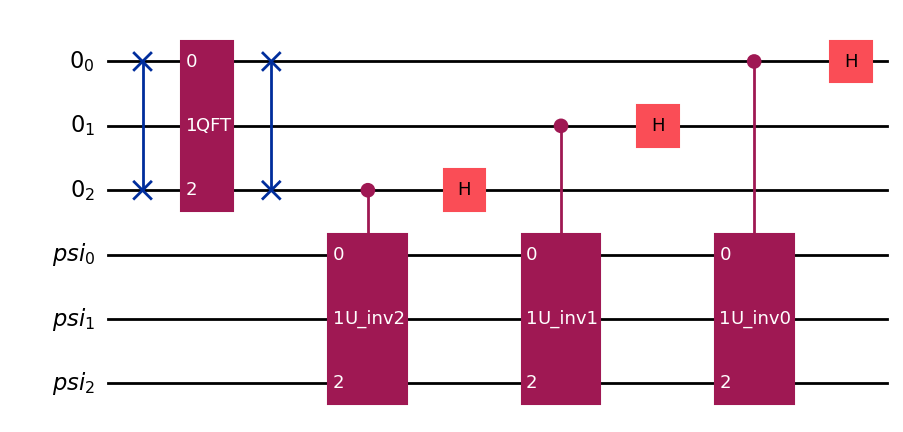

In [112]:
QPE_dagger(d,n,thetas).draw(output="mpl")

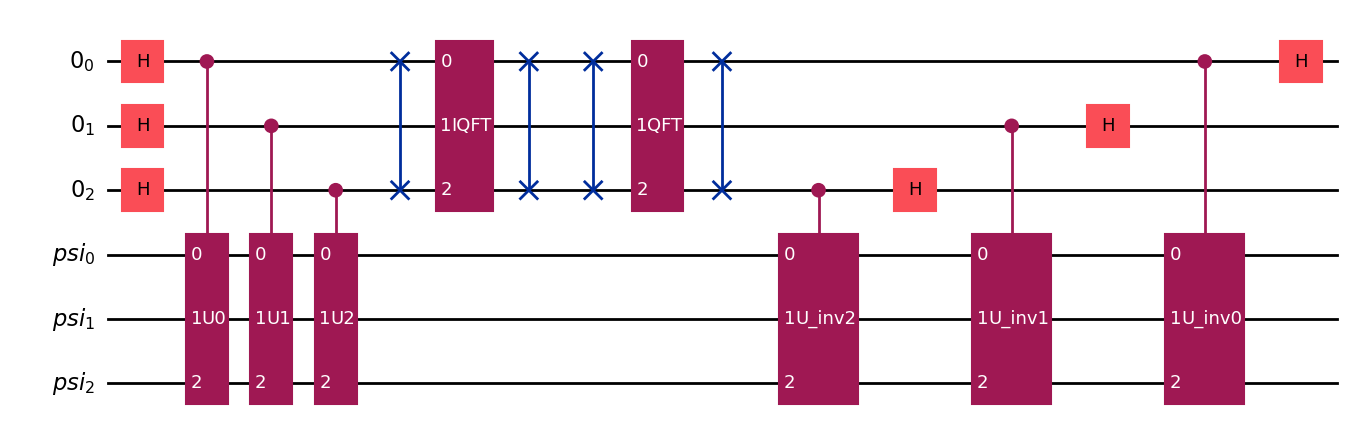

In [113]:
# Check if QPE composed with QPE_dagger gives identity
qr_0_check = QuantumRegister(size=d,name="0")
qr_psi_check = QuantumRegister(size=n, name="psi")
qc_check = QuantumCircuit(qr_0_check, qr_psi_check, name=f'id')
qc_check.compose(QPE(d,n,thetas),inplace=True)
qc_check.compose(QPE_dagger(d,n,thetas),inplace=True)
qc_check.draw(output="mpl")

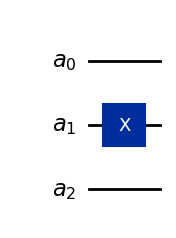

In [114]:
## The above circuit is useful on its own, so I am going to keep it.

# Now if I do not bake in the initial condition directly into the following circuit, it will become difficult later to chain the "Z_f"
# Grover's algorithm with the other operators. So I will bake in the initial condition with the |0>_d qubits, and construct Z_f.
# However, psi remains in our circuit.

#First let's make a function that puts the X gates in the right place to create the initial conditions for a number alpha in 2^d-1 |alpha>
qr = QuantumRegister(size=3, name = "a")
def initial_conditions(alpha, qr): #Input : number alpha, quantum register qr
    qc = QuantumCircuit(qr)
    
    d = len(qr)
    bit_str = bit_string(alpha,d)[::-1] # I need to reverse because of qiskit indexing of register
    for i in range(d):
        if bit_str[i] == '1':
            qc.x(qr[i])
    return qc

initial_conditions(2,qr).draw(output="mpl")

In [ ]:
def unscramble(t, qr):
    # this converts |t>_d to |2^d-1>_d so that it is only this combination 
    # that will flip sign when a multi-controlled Z is applied in U_f
    # Input: t, quantum_register qr
    qc = QuantumCircuit(qr)
    
    d = len(qr)
    alpha = 2**d-1-t
    bit_str = bit_string(alpha,d)[::-1] # I need to reverse because of qiskit indexing of register
    for i in range(d):
        if bit_str[i] == '1':
            qc.x(qr[i])
    return qc

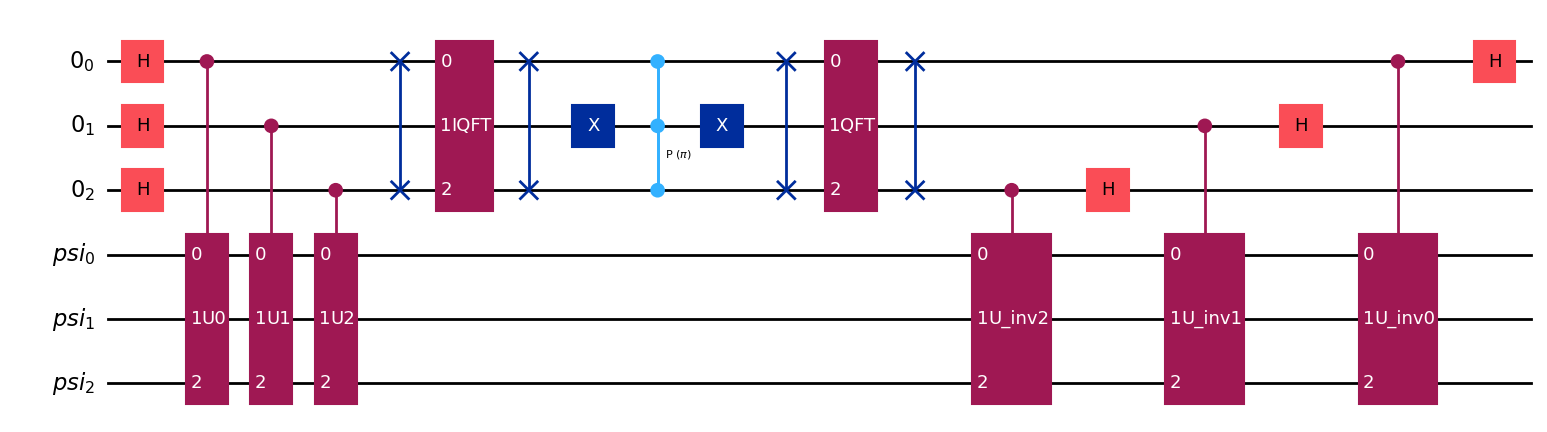

In [119]:
#This function measures what comes out of the QPE above. The "measurement" is performed by sampling over the probability distribution
# of the final state vector produced by the QPE circuit, and returning the "collapsed" state as a bit-string. 

# We do not construct MCP gate from scratch but use the qiskit implementation here. For how to construct this gate, refer to nb 1.

t = 5


def U_f(d,n,thetas): # sv_ini is Initial State Vector to feed in to QPE


    qr_0= QuantumRegister(size=d,name="0")
    qr_psi = QuantumRegister(size=n,name="psi")

    qc = QuantumCircuit(qr_0,qr_psi)
        
    qc_qpe = QPE(d,n,thetas)
    qc.compose(qc_qpe, qubits=qr_0[:] + qr_psi[:],inplace=True)
        
    qc_0_unscrambled = unscramble(t,qr_0)
    qc.compose(qc_0_unscrambled, qubits = qr_0, inplace=True)

    qc.mcp(np.pi, qr_0[:d-1],qr_0[d-1])

    qc.compose(qc_0_unscrambled, qubits = qr_0, inplace=True) # it is its own inverse.
    
    qc_qpe_dagger = QPE_dagger(d,n,thetas)
    qc.compose(qc_qpe_dagger, qubits = qr_0[:] + qr_psi[:], inplace=True)

    return qc

qc = U_f(d,n,thetas)
qc.draw(output="mpl")

    
    

In [120]:
# For modularity, I will now implement the H^n Z_OR H^n where Z_OR = X^n C^{n-1}Z X^n

def Z_or(n):

    qr_psi = QuantumRegister(size=n,name="psi")
    qc_z_or = QuantumCircuit(qr_psi,name=f'z_or')

    #qc_z_or.h(qr_psi)
    qc_z_or.x(qr_psi)

    qc_z_or.mcp(np.pi, qr_psi[0:n-1],qr_psi[-1]) # C^(n-1)Z

    qc_z_or.x(qr_psi)
    
    

    return qc_z_or

Z_or(3).draw(output="mpl")

print(np.round(Operator(Z_or(3)).data))
    

print("We have indeed implemented a Z_or which is pretty cool.")

[[-1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.-0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
We have indeed implemented a Z_or which is pretty cool.


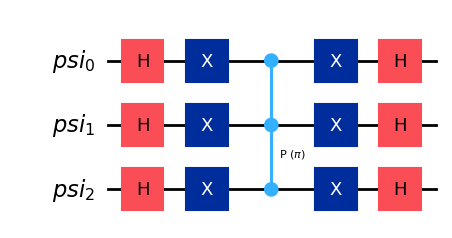

In [121]:
def S(n):
    qr_psi = QuantumRegister(size=n,name="psi")
    qc = QuantumCircuit(qr_psi, name=f'S') # Akos notation

    qc.h(qr_psi)
    qc.compose(Z_or(n),qubits=qr_psi,inplace=True)
    qc.h(qr_psi)

    return qc

S(3).draw(output="mpl")
    

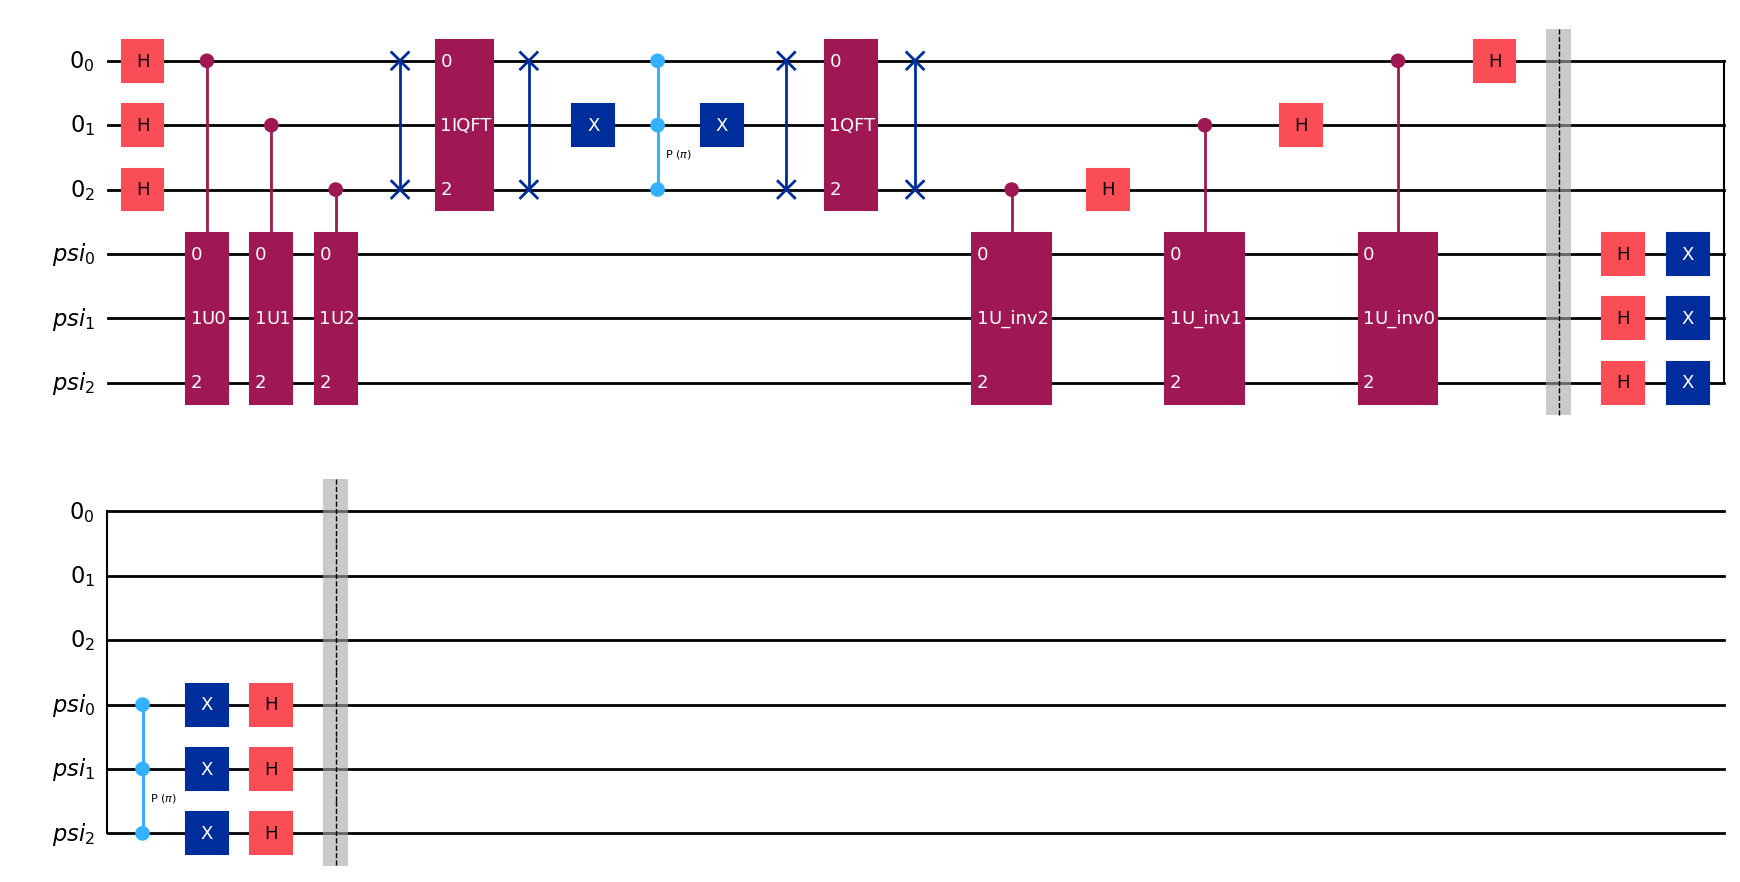

In [128]:
# Now we define G = - S . U_f
# I'm not sure how to do a minus sign. It's also not important, as we will converge to the correct state up to a sign.

def G(d,n,thetas):
    qr_0= QuantumRegister(size=d,name="0")
    qr_psi = QuantumRegister(size=n,name="psi")

    qc = QuantumCircuit(qr_0,qr_psi)
    
    qc.compose(U_f(d,n,thetas),qubits = qr_0[:] + qr_psi[:],inplace=True)
    qc.barrier()
    qc.compose(S(n),qubits = qr_psi[:], inplace=True)
    qc.barrier()
    return qc

#psi = 5
qc = G(d,n,thetas)
qc.draw(output="mpl")
    
    

# Let's determine how many times we need to apply G. 
After $k$ iterations of Grover $G$, the probability of getting the key is given by
\begin{equation}
P = \sin^2 \left [ (2 k + 1) \sin^{-1} \left (\frac{1}{2^{n/2}} \right )  \right ]
\end{equation}
We maximize the probability by taking the argument to be $\simeq \pi/2$. This gives
\begin{equation}
k = \left \lfloor \frac{\pi}{4 \sin^{-1} \left ( \frac{1}{2^{n/2}} \right )} - \frac{1}{2} \right \rfloor
\end{equation}

In [129]:
print(np.pi/(4*np.arcsin(1/(2**(5/2)))) - 1/2)

3.919534679768386


In [132]:
# This function computes the number of iterations k needed to converge to the correct state in Grover's algorithm.
def k_iterations(n):
    return np.floor(np.pi/(4*np.arcsin(1/(2**(n/2)))) - 1/2).astype(int)

print(k_iterations(4))

2


In [143]:
def Grover_k(d,n,thetas,k):
    qr_0= QuantumRegister(size=d,name="0")
    qr_psi = QuantumRegister(size=n,name="psi")

    qc = QuantumCircuit(qr_0,qr_psi)

    #create state |s> as an equal superposition of ALL basis states
    qc.h(qr_psi)

    

    for i in range(k):
        qc.barrier()

        qc.compose(G(d,n,thetas),qubits = qr_0[:] + qr_psi[:],inplace=True)
        

    
    
    return qc

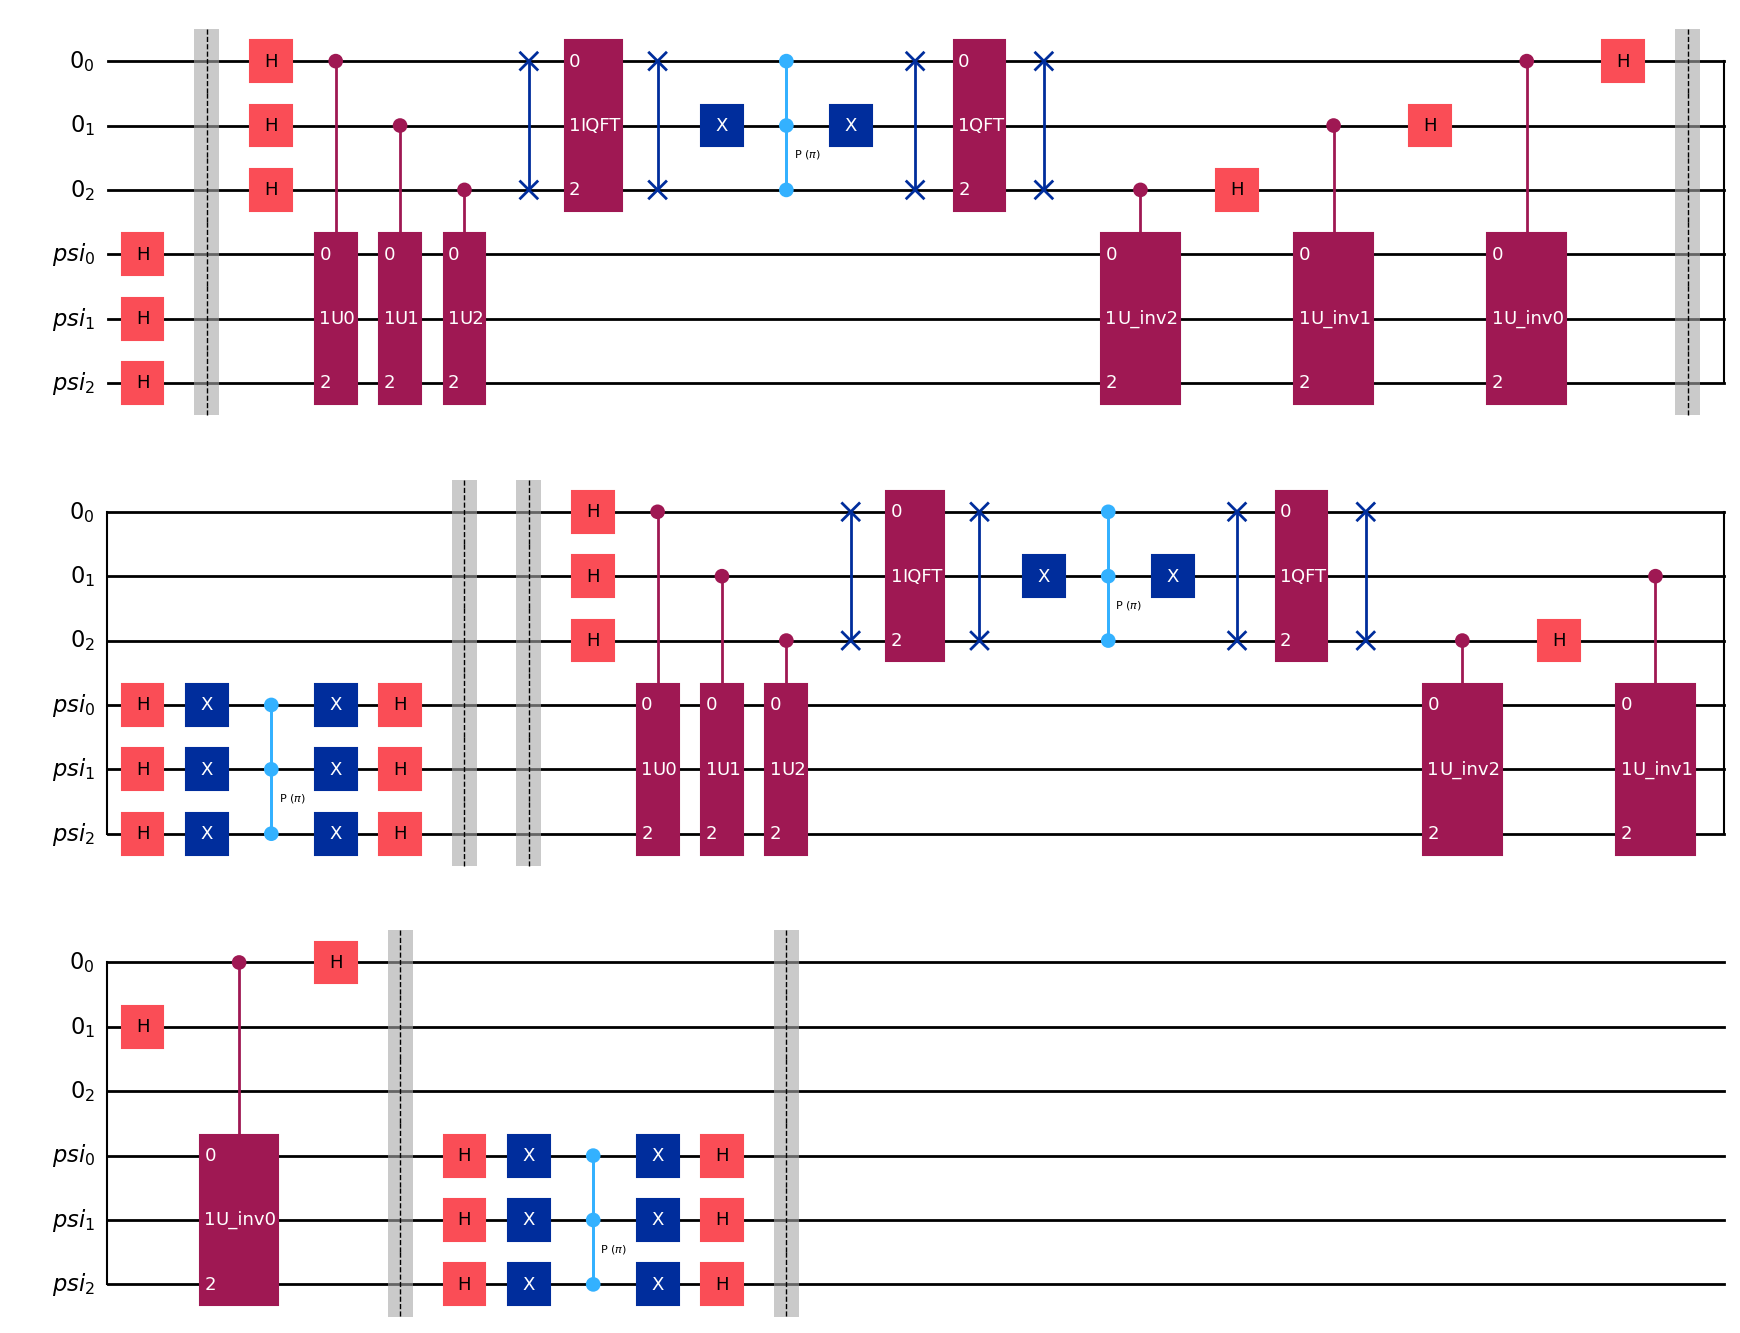

In [144]:
k=2
Grover_k(d,n,thetas,k).draw(output="mpl")

We now present our final solution below. First start by selecting $n$ and $d$ making sure that $d>n$

In [278]:
d = 6
n = 6

Now we will randomly generate the list of $\theta$ values to be used

In [279]:
thetas = theta_input(d,n)
print(thetas)

[0.3125   0.546875 0.515625 0.421875 0.796875 0.5      0.390625 0.96875
 0.640625 0.578125 0.671875 0.296875 0.78125  0.15625  0.015625 0.625
 0.65625  0.59375  0.984375 0.921875 0.046875 0.09375  0.03125  0.359375
 0.90625  0.75     0.890625 0.375    0.703125 0.765625 0.125    0.21875
 0.1875   0.71875  0.265625 0.5625   0.28125  0.328125 0.203125 0.828125
 0.25     0.109375 0.875    0.34375  0.140625 0.4375   0.40625  0.484375
 0.734375 0.0625   0.171875 0.234375 0.       0.53125  0.6875   0.609375
 0.859375 0.46875  0.84375  0.453125 0.8125   0.078125 0.9375   0.953125]


From the list above select one value to use as $t$

In [280]:
t_choice = 0.5

#Now we globally set t to the value we want to find
t = int(t_choice*2**d)


Now we construct a circuit that runs Grover's algorithm the optimal number of times

In [281]:
k= k_iterations(n) #k_iterations(n)
qc = Grover_k(d,n,thetas,k)
#qc.draw(output="mpl")


From here, we would would perform a measurement on $\psi$ and the correct state or states that satisfy the problem statement would have the highest probability of being measured. Here we will show which states have the highest probabilities of being selected.

In [282]:
sv_fin = Statevector(qc)
probs = sv_fin.probabilities()
#n_qubits = sv_fin.num_qubits
print("The expected value stored in |0>_d is",0)#2**d-1-t)
print("")
print("The value stored in |0>_d is",num_output(bit_string(np.random.choice(2**(d+n),p=probs),d+n)[::-1],d,n))

The expected value stored in |0>_d is 0

The output value of psi is 5
The value stored in |0>_d is 5


In [283]:
for i in range(len(probs)):
    if probs[i]>0.1:
        print(probs[i])
        print(i)

0.9635154816191799
320


In [284]:
len(probs)

4096

In [285]:
psis = np.array([])
for i in range(len(probs)):
    psi = num_output(bit_string(i,d+n)[::-1],d,n)
    psis = np.append(psis, psi)

The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output value of psi is 0
The output val

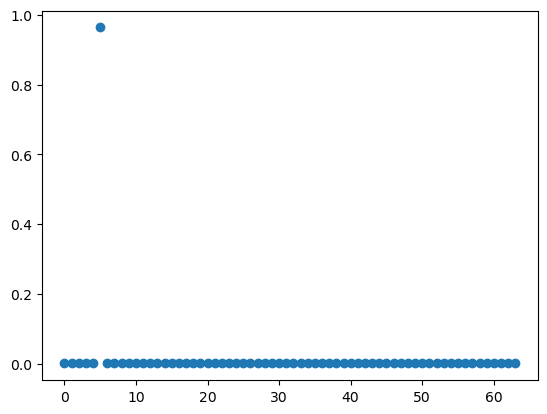

In [286]:
plt.scatter(psis[0::2**d],probs[0::2**d])